# Importing Libraries

In [2]:
# importing Necessary Libraries and packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from matplotlib.image import imread 
from PIL import Image
import tensorflow as tf
from skimage import exposure
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report,confusion_matrix

# Importing the Dataset and the setting the paths

In [3]:
#Creating a Directory for the Dataset
main_dirction_path = '../input/chest-xray-pneumonia/chest_xray'
print(os.listdir(main_dirction_path))

['chest_xray', '__MACOSX', 'val', 'test', 'train']


In [4]:
# Making Paths for Train , test and validation 
train_folder_path = main_dirction_path + '/train/'
test_folder_path = main_dirction_path + '/test/'
val_folder_path = main_dirction_path + '/val/'

In [5]:
os.listdir(train_folder_path)

['PNEUMONIA', 'NORMAL']

In [6]:
train_n_path = train_folder_path+'/NORMAL/'
train_p_path = train_folder_path+'/PNEUMONIA/'

test_n_path = test_folder_path+'/NORMAL/'
test_p_path = test_folder_path+'/PNEUMONIA/'

In [7]:
# Total Images 
print(len(os.listdir(train_n_path))) #length of normal training images
print(len(os.listdir(train_p_path))) #length of pneumonia training images 
print('TOTAL TRAIN IMAGES:', len(os.listdir(train_n_path)) + len(os.listdir(train_p_path)))

1341
3875
TOTAL TRAIN IMAGES: 5216


# Explor Data Visualisation (EDA)

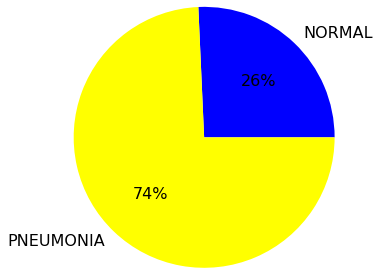

In [8]:
# Pie Chart of the Train Dataset
x = np.array([len(os.listdir(train_n_path)),len(os.listdir(train_p_path))])
labels = ['NORMAL', 'PNEUMONIA']
colors = {'NORMAL': 'Blue','PNEUMONIA': 'yellow' }
plt.pie(x, labels = labels, autopct = '%.0f%%', radius= 1.5, colors = [colors[key] for key in labels], textprops={'fontsize': 16})
plt.show()

# Image of Pneumonia and Normal X-ray 

(-0.5, 1367.5, 927.5, -0.5)

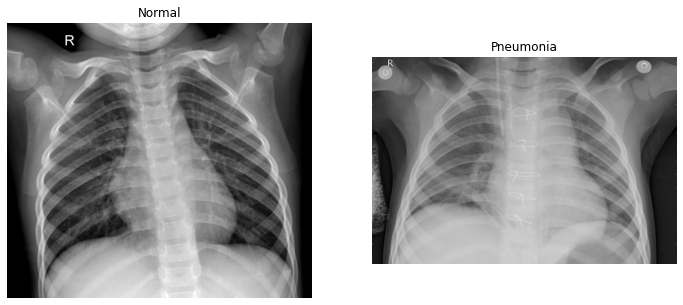

In [9]:
random_normal= np.random.randint(0,len(os.listdir(train_n_path))) 
normal_img = os.listdir(train_n_path)[random_normal]
normal_img_address = train_n_path+normal_img

# Choose random image from pneumonia folder
random_pneumonia = np.random.randint(0,len(os.listdir(train_p_path)))
pneumonia_img =  os.listdir(train_p_path)[random_pneumonia]
pneumonia_img_address = train_p_path+pneumonia_img

#Load 2 images
normal_load = Image.open(normal_img_address)
pneumonia_load = Image.open(pneumonia_img_address)

#Visulaizaion 
figure = plt.figure(figsize= (12,12))
img1 = figure.add_subplot(1,2,1)
img_plot = plt.imshow(normal_load, cmap = 'gray')
img1.set_title('Normal')
plt.axis("off")

img2 = figure.add_subplot(1, 2, 2)
img_plot = plt.imshow(pneumonia_load, cmap = 'gray')
img2.set_title('Pneumonia')
plt.axis("off")

In [10]:
normal_load.size

(1746, 1576)

In [11]:
pneumonia_load.size

(1368, 928)

# Visulaization random samples of Normal images and Pneumonia images:

In [12]:
def show_normal_images (number):
    plt.figure(figsize=(16,16))
    for n in range(number):
        normal_img = os.listdir(train_n_path)[n]
        normal_img_address = train_n_path+normal_img
        normal_load = Image.open(normal_img_address)
        ax = plt.subplot(5,5,n+1)
        plt.imshow(normal_load, cmap ='gray')
        plt.title("NORMAL")
        plt.axis("off")
        
def show_pneumonia_images (number):
    plt.figure(figsize=(16,16))
    for n in range(number):
        pneumonia_img =  os.listdir(train_p_path)[n]
        pneumonia_img_address = train_p_path+pneumonia_img
        pneumonia_load = Image.open(pneumonia_img_address)
        ax = plt.subplot(5,5,n+1)
        plt.imshow(pneumonia_load, cmap ='gray')
        plt.title("PNEUMONIA")
        plt.axis("off")

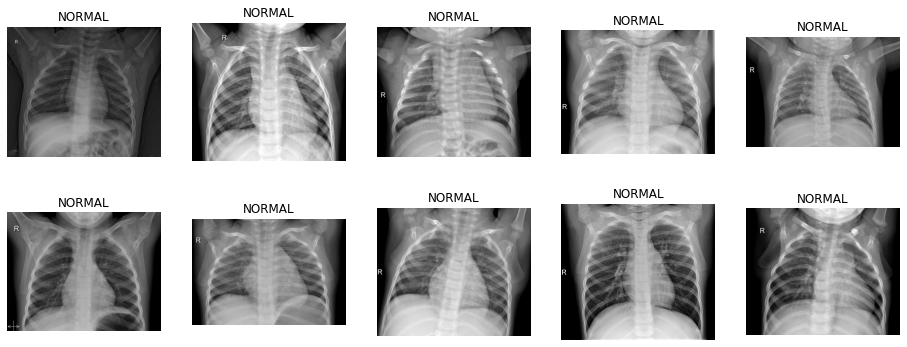

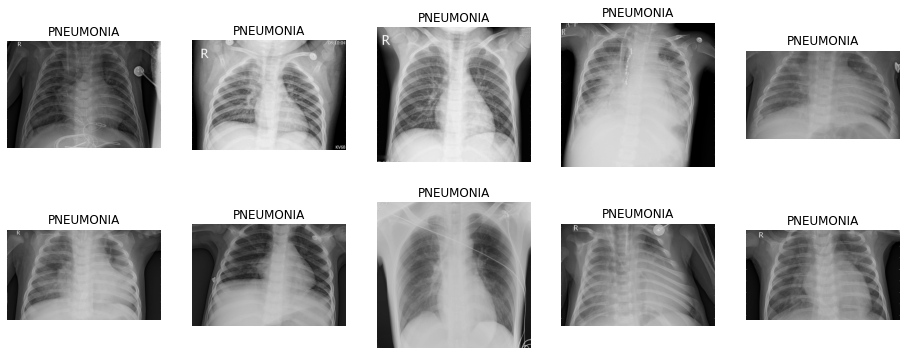

In [13]:
show_normal_images(10)
show_pneumonia_images(10)

In [36]:
pneumonia_load.size

(1368, 928)

In [37]:
normal_load.size

(1746, 1576)

# Data Preprocessing

Most machine learning algorithms are not very useful with biased class data. But, we can modify   the current training algorithm **to take into account the skewed distribution of the classes.** This can be achieved by **giving different weights to both the majority and minority classes**. The difference in weights **will influence the classification of the classes during the training phase**. The whole purpose is to penalize the misclassification made by the minority class by setting a higher class weight and at the same time reducing weight for the majority class. 

The formula to calculate this is:  

**Wj = n_samples / (n_classes * n_samplesj)**  

Wj is the weight for each class(j signifies the class).  
n_samples is the total number of samples or rows in the dataset.  
n_classes is the total number of unique classes in the target.  
n_samplesj is the total number of rows of the respective class.  

In [14]:
img = np.asarray(normal_load)
image_eq = exposure.equalize_hist(img)

(-0.5, 1745.5, 1575.5, -0.5)

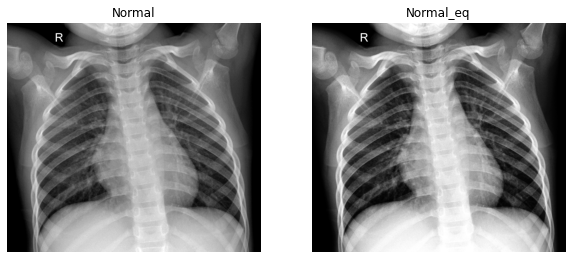

In [15]:
figure1 = plt.figure(figsize= (10,10))
img_1 = figure1.add_subplot(1,2,1)
img_plot = plt.imshow(img, cmap = 'gray')
img_1.set_title('Normal')
plt.axis("off")

img2 = figure1.add_subplot(1, 2, 2)
img_plot = plt.imshow(image_eq, cmap = 'gray')
img2.set_title('Normal_eq')
plt.axis("off")

In [16]:
def equlize_hist_ (image):
  _image = np.asarray(image)
  image_eq = exposure.equalize_hist(_image)
  return image_eq

In [17]:
os.listdir(train_folder_path)

['PNEUMONIA', 'NORMAL']

# Improve Class Imbalance using Class Weights:

In [18]:
TRAIN_IMG_COUNT = len(os.listdir(train_n_path)) + len(os.listdir(train_p_path))
COUNT_NORMAL = len(os.listdir(train_n_path))
COUNT_PNEUMONIA = len(os.listdir(train_p_path))

weight_for_0 = TRAIN_IMG_COUNT / (2 * COUNT_NORMAL)
weight_for_1 = TRAIN_IMG_COUNT / (2 * COUNT_PNEUMONIA)

class_weight = {0: weight_for_0, 1: weight_for_1}

****ImageDataGenerator augments your image by iterating through   
****image as your CNN is getting ready to process that image

In [19]:
img_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   validation_split = 0.25,
                                   horizontal_flip = True)


training_set = img_datagen.flow_from_directory('../input/chest-xray-pneumonia/chest_xray/train',
                                                 target_size = (256, 256),
                                                 batch_size = 5,
                                                 color_mode='grayscale',
                                                 subset='training',
                                                 class_mode = 'binary')

validation_generator = img_datagen.flow_from_directory('../input/chest-xray-pneumonia/chest_xray/train',
                                                        target_size=(256, 256),
                                                        batch_size=5,
                                                        subset="validation",
                                                        color_mode='grayscale',
                                                        class_mode='binary')

test_set = img_datagen.flow_from_directory('../input/chest-xray-pneumonia/chest_xray/test',
                                            target_size = (256, 256),
                                            batch_size = 5,
                                            color_mode='grayscale',
                                            shuffle=False,
                                            class_mode = 'binary')

Found 3913 images belonging to 2 classes.
Found 1303 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


# CNN Model

In [20]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 1)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

2022-12-19 13:46:54.005186: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-19 13:46:54.006601: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-19 13:46:54.230580: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-19 13:46:54.232059: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-19 13:46:54.233274: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      320       
_________________________________________________________________
batch_normalization (BatchNo (None, 254, 254, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 252, 252, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 252, 252, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 126, 126, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 126, 126, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 124, 124, 64)      1

In [38]:
cnn_model = model.fit(training_set,
                      epochs = 20 ,
                      steps_per_epoch = training_set.samples // 5,
                      validation_data = validation_generator,
                      validation_steps = validation_generator.samples // 5,
                      class_weight = class_weight 
                      )

Epoch 1/20
782/782 [==============================] - 96s 123ms/step - loss: 0.3496 - accuracy: 0.8501 - val_loss: 0.2606 - val_accuracy: 0.8885
Epoch 2/20
782/782 [==============================] - 96s 122ms/step - loss: 0.3456 - accuracy: 0.8529 - val_loss: 0.2459 - val_accuracy: 0.9046
Epoch 3/20
782/782 [==============================] - 96s 123ms/step - loss: 0.3202 - accuracy: 0.8669 - val_loss: 0.2546 - val_accuracy: 0.8915
Epoch 4/20
782/782 [==============================] - 96s 122ms/step - loss: 0.3175 - accuracy: 0.8751 - val_loss: 0.3161 - val_accuracy: 0.8685
Epoch 5/20
782/782 [==============================] - 95s 122ms/step - loss: 0.2962 - accuracy: 0.8828 - val_loss: 0.3867 - val_accuracy: 0.8477
Epoch 6/20
782/782 [==============================] - 108s 139ms/step - loss: 0.2923 - accuracy: 0.8820 - val_loss: 0.2333 - val_accuracy: 0.8977
Epoch 7/20
782/782 [==============================] - 116s 148ms/step - loss: 0.3529 - accuracy: 0.8559 - val_loss: 0.7732 - val_

# Loss vs Val_loss 

<AxesSubplot:>

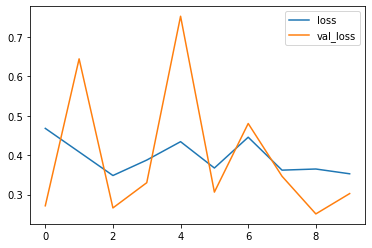

In [23]:
losses = pd.DataFrame(model.history.history)
losses[['loss','val_loss']].plot()

# Accuracy vs Val_Accuracy

<AxesSubplot:>

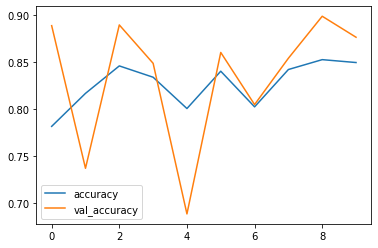

In [24]:
losses[['accuracy','val_accuracy']].plot()

# Model Evaluate

In [25]:
loss, acc = model.evaluate(test_set)

125/125 [==============================] - 13s 106ms/step - loss: 0.3682 - accuracy: 0.8558


# Saving the Model

In [26]:
model.save('CNN_PNEUMONIA.h5')

# Getting the Predictions

In [27]:
Predections = model.predict(test_set)

In [28]:
Predections = (Predections>0.5).astype(np.int)

In [29]:
print(classification_report(test_set.classes, Predections, target_names = ['Normal', 'Pneumonia']))

              precision    recall  f1-score   support

      Normal       0.80      0.74      0.77       234
   Pneumonia       0.85      0.89      0.87       390

    accuracy                           0.83       624
   macro avg       0.83      0.81      0.82       624
weighted avg       0.83      0.83      0.83       624



# Confusion Matrix

In [30]:
confusion_matrix(test_set.classes, Predections>0.5)

array([[172,  62],
       [ 42, 348]])

<AxesSubplot:>

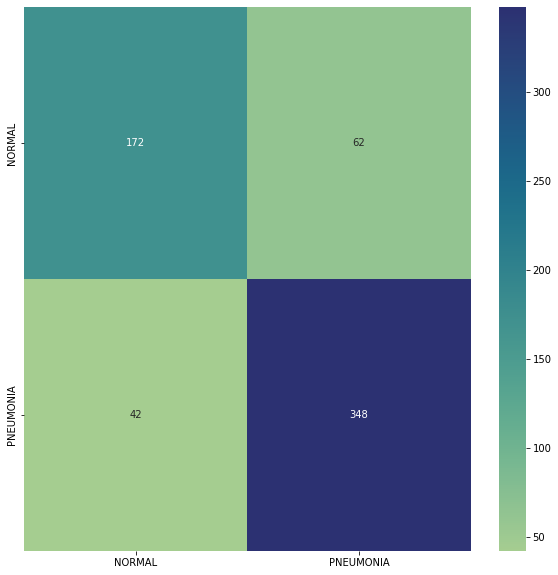

In [31]:
plt.figure(figsize = (10,10))
sns.heatmap(confusion_matrix(test_set.classes, Predections>0.5),cmap= "crest", 
            annot = True, fmt='',xticklabels = labels,yticklabels = labels)

# Visualizing the Results with Dataset

In [32]:
correct_pred = np.nonzero(Predections == test_set.classes)[0]
incorrect_pred = np.nonzero(Predections != test_set.classes)[0]

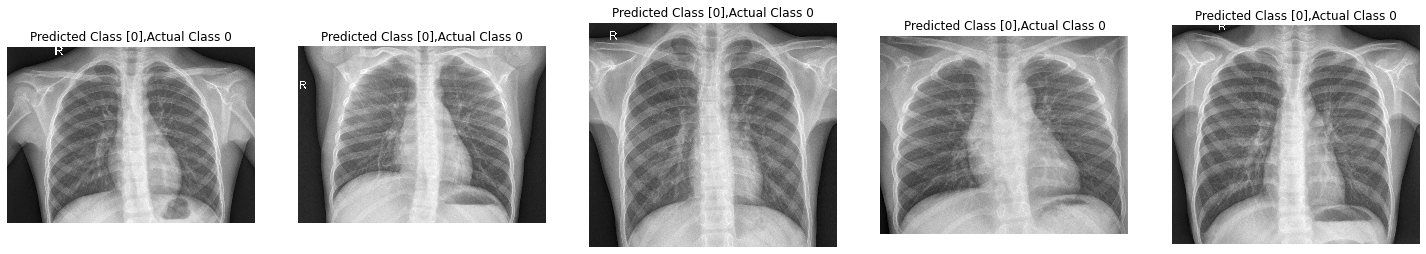

In [33]:
i = 0
figure = plt.figure(figsize= (20,20))
for c in correct_pred[:5]:
    ax = plt.subplot(5,5,i+1)
    plt.imshow(Image.open(test_set.filepaths[i]), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(Predections[c], test_set.classes[c]))
    plt.tight_layout()
    plt.axis("off")
    i += 1

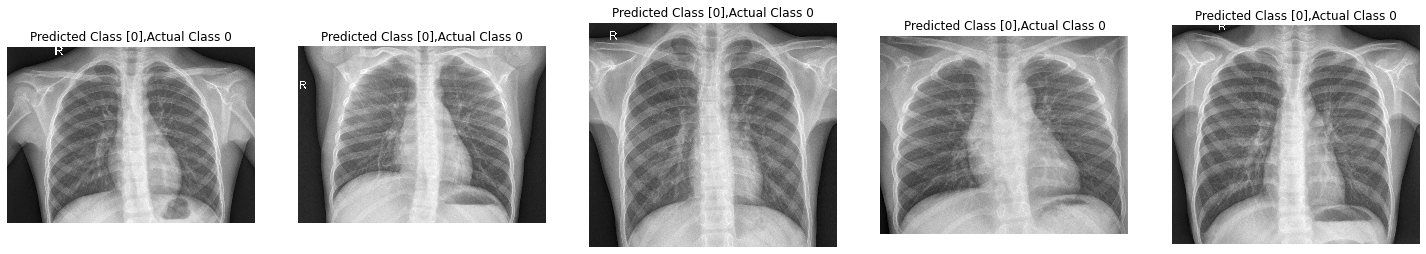

In [34]:
i = 0
figure = plt.figure(figsize= (20,20))
for c in incorrect_pred[:5]:
    ax = plt.subplot(5,5,i+1)
    plt.imshow(Image.open(test_set.filepaths[i]), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(Predections[c], test_set.classes[c]))
    plt.tight_layout()
    plt.axis("off")
    i += 1

# Loss and the Accuracy of the model

In [35]:
print("Loss of the model is - " , model.evaluate(test_set)[0]*100 , "%")
print("Accuracy of the model is - " , model.evaluate(test_set)[1]*100 , "%")

125/125 [==============================] - 10s 81ms/step - loss: 0.3584 - accuracy: 0.8365
Loss of the model is -  35.83584725856781 %
125/125 [==============================] - 9s 74ms/step - loss: 0.3323 - accuracy: 0.8574
Accuracy of the model is -  85.73718070983887 %
